### In this notebook we will be taking the original South German Credit dataset and adding bias against foreign workers

In [1]:
%%capture 
#Cell Magic to hide output

#For Synthetic Data Generation
!pip install sdv
#Imports
import pandas as pd
from sagemaker.s3 import S3Downloader
from sdv.tabular import GaussianCopula

### Download data

First,  __download__ the data and save it in the `data` folder.


$^{[2]}$ Ulrike Grömping
Beuth University of Applied Sciences Berlin
Website with contact information: https://prof.beuth-hochschule.de/groemping/.

In [2]:
#Load data from s3
S3Downloader.download(
    "s3://sagemaker-sample-files/datasets/tabular/uci_statlog_german_credit_data/SouthGermanCredit.asc",
    "data",
)
#Set Column names
credit_columns = [
    "status",
    "duration",
    "credit_history",
    "purpose",
    "amount",
    "savings",
    "employment_duration",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker",
    "credit_risk",
]
#Load South German Credit data
training_data = pd.read_csv(
    "data/SouthGermanCredit.asc",
    names=credit_columns,
    header=0,
    sep=r" ",
    engine="python",
    na_values="?",
).dropna()
#Take a look at first 5 rows of data
training_data.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


### Explanation of Data Features

$`laufkont = status`
                                               
 1 : no checking account                       
 2 : ... < 0 DM                                
 3 : 0<= ... < 200 DM                          
 4 : ... >= 200 DM / salary for at least 1 year

$`laufzeit = duration`
     

$`moral = credit_history`
                                                
 0 : delay in paying off in the past            
 1 : critical account/other credits elsewhere   
 2 : no credits taken/all credits paid back duly
 3 : existing credits paid back duly till now   
 4 : all credits at this bank paid back duly    

$`verw = purpose`
                        
 0 : others             
 1 : car (new)          
 2 : car (used)         
 3 : furniture/equipment
 4 : radio/television   
 5 : domestic appliances
 6 : repairs            
 7 : education          
 8 : vacation           
 9 : retraining         
 10 : business          

$`hoehe = amount`
     

$`sparkont = savings`
                               
 1 : unknown/no savings account
 2 : ... <  100 DM             
 3 : 100 <= ... <  500 DM      
 4 : 500 <= ... < 1000 DM      
 5 : ... >= 1000 DM            

$`beszeit = employment_duration`
                     
 1 : unemployed      
 2 : < 1 yr          
 3 : 1 <= ... < 4 yrs
 4 : 4 <= ... < 7 yrs
 5 : >= 7 yrs        

$`rate = installment_rate`
                   
 1 : >= 35         
 2 : 25 <= ... < 35
 3 : 20 <= ... < 25
 4 : < 20          

$`famges = personal_status_sex`
                                         
 1 : male : divorced/separated           
 2 : female : non-single or male : single
 3 : male : married/widowed              
 4 : female : single                     

$`buerge = other_debtors`
                 
 1 : none        
 2 : co-applicant
 3 : guarantor   

$`wohnzeit = present_residence`
                     
 1 : < 1 yr          
 2 : 1 <= ... < 4 yrs
 3 : 4 <= ... < 7 yrs
 4 : >= 7 yrs        

$`verm = property`
                                              
 1 : unknown / no property                    
 2 : car or other                             
 3 : building soc. savings agr./life insurance
 4 : real estate                              

$`alter = age`
     

$`weitkred = other_installment_plans`
           
 1 : bank  
 2 : stores
 3 : none  

$`wohn = housing`
             
 1 : for free
 2 : rent    
 3 : own     

$`bishkred = number_credits`
         
 1 : 1   
 2 : 2-3 
 3 : 4-5 
 4 : >= 6

$`beruf = job`
                                               
 1 : unemployed/unskilled - non-resident       
 2 : unskilled - resident                      
 3 : skilled employee/official                 
 4 : manager/self-empl./highly qualif. employee

$`pers = people_liable`
              
 1 : 3 or more
 2 : 0 to 2   

$`telef = telephone`
                              
 1 : no                       
 2 : yes (under customer name)

$`gastarb = foreign_worker`
        
 1 : yes
 2 : no 

$`kredit = credit_risk`
         
 0 : bad 
 1 : good


### Synthetic Data Generation 

Synthetic data generation is an effective tool when studying model bias. Data can be biased towards or against specific groups or sub-groups. By generating biased data we can observe how our AI models behave towards a specific group or sub-group. One such sub-group we can examine are Foreign Workers. The model under inspection labels its predictions as 0(Bad credit) or 1(good credit), we can artificially lower their credit worthiness compared to other groups’ through synthetic data generation. 

For the data generation we will be using Synthetic Data Vault (https://sdv.dev/SDV/) or SDV for short.  SDV is a python library that allows you to generate synthetic data that is agreeable with the statistical nature of the original dataset.

In [3]:
#Parameters for generated data

#How many rows of synthetic data 
Rows = 100

#Select all foreign workers who were accepted (foreign_worker value 1 credit risk 1) 
ForeignWorkerData = training_data.loc[(training_data['foreign_worker'] == 1) & (training_data['credit_risk'] == 1)]
ForeignWorkerData

#Fit Foreign Worker data to SDV model (ignore warning)
model = GaussianCopula()
model.fit(ForeignWorkerData)

#Generate Synthetic foreign worker data based on rows stated 
SynthForeignWorkers = model.sample(Rows)

/opt/conda/lib/python3.8/site-packages/copulas/univariate/truncated_gaussian.py:45: RuntimeWarning: invalid value encountered in double_scalars
  a = (self.min - loc) / scale
/opt/conda/lib/python3.8/site-packages/copulas/univariate/truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale


In [4]:
#We generated 100 new synthetic records of Foreign Workers based on Foreign Workers who were accepted in the original dataset. We will now take those records and convert the "credit_risk" label to 
#0 (bad credit). This will mark these Foreign Workers unfairly as bad credit, hence inserting bias into our dataset
SynthForeignWorkers.loc[SynthForeignWorkers['credit_risk'] == 1, 'credit_risk'] = 0 
SynthForeignWorkers.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,3,13,3,2,3583,3,3,3,2,1,...,3,55,3,2,1,3,2,2,1,0
1,4,10,0,2,1148,4,3,3,3,2,...,2,30,3,2,1,3,2,1,1,0
2,2,13,1,2,2032,2,4,2,3,3,...,1,22,2,1,1,3,2,1,1,0
3,1,24,3,4,6541,5,2,4,2,2,...,3,31,2,2,1,3,2,2,1,0
4,4,9,4,2,2129,2,4,2,3,1,...,2,38,3,2,2,3,1,2,1,0


In [5]:
#Create new dataset with Synthetic Foreign workers (100) + Original South German Credit Risk (1000)
frames = [training_data, SynthForeignWorkers]
BiasedData1 = pd.concat(frames)
BiasedData1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   status                   1100 non-null   int64
 1   duration                 1100 non-null   int64
 2   credit_history           1100 non-null   int64
 3   purpose                  1100 non-null   int64
 4   amount                   1100 non-null   int64
 5   savings                  1100 non-null   int64
 6   employment_duration      1100 non-null   int64
 7   installment_rate         1100 non-null   int64
 8   personal_status_sex      1100 non-null   int64
 9   other_debtors            1100 non-null   int64
 10  present_residence        1100 non-null   int64
 11  property                 1100 non-null   int64
 12  age                      1100 non-null   int64
 13  other_installment_plans  1100 non-null   int64
 14  housing                  1100 non-null   int64
 15  number

In [6]:
#Store dataframe for use in Notebook 2 and 3
%store BiasedData1

Stored 'BiasedData1' (DataFrame)


### Data inspection

In [7]:
#Length of Biased Data
len(BiasedData1)

1100

In [8]:
#View first 5 lines of biased dataset
BiasedData1.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


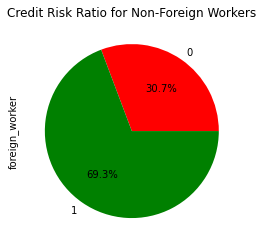

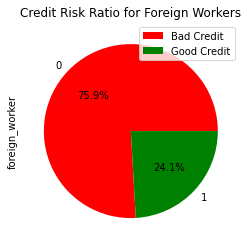

In [9]:
#Pie Charts for good credit/bad credit labels for Foreign Workers vs. Non-Foreign Workers 

#Imports 
import matplotlib.pyplot as plt
import seaborn as sns

#Select all Non-Foreign workers in the dataset
BiasedDataNonForeign = BiasedData1[BiasedData1['foreign_worker']==2]
#Select all Foreign workers in the dataset
BiasedDataForeign = BiasedData1[BiasedData1['foreign_worker']==1]
#Pie Chart for Non-Foreign workers good credit/bad credit
BiasedDataNonForeign.groupby(['credit_risk']).sum().plot(kind='pie', y='foreign_worker', autopct='%1.1f%%', colors = ['red','green'], legend = None)
plt.title('Credit Risk Ratio for Non-Foreign Workers')
plt.show()
#Pie Chart for Foreign workers good credit/bad credit
BiasedDataForeign.groupby(['credit_risk']).sum().plot(kind='pie', y='foreign_worker', autopct='%1.1f%%', colors = ['red','green'])
plt.title('Credit Risk Ratio for Foreign Workers')
plt.legend(labels=["Bad Credit","Good Credit"])
plt.show()

In [10]:
#Check how many Foreign workers there are vs. Non-Foreign Workers
print("Number of Foreign Workers: ",BiasedData1['foreign_worker'].value_counts()[1])
print("Number of Non-Foreign Workers: ",BiasedData1['foreign_worker'].value_counts()[2])

Number of Foreign Workers:  137
Number of Non-Foreign Workers:  963


Data Processing

In [11]:
#Imports
from sagemaker.s3 import S3Uploader
from sagemaker import Session
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker import get_execution_role
from sagemaker.processing import ProcessingInput, ProcessingOutput

session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/sagemaker-amt-credit-risk-model"
region = session.boto_region_name
role = get_execution_role()

training_data = BiasedData1 

In [12]:
# prepare raw test data
test_data = training_data.sample(frac=0.1)
test_data = test_data.drop(["credit_risk"], axis=1)
test_filename = "test.csv"
test_columns = [
    "status",
    "duration",
    "credit_history",
    "purpose",
    "amount",
    "savings",
    "employment_duration",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker",
]
test_data.to_csv(test_filename, index=False, header=True, columns=test_columns, sep=",")

# prepare raw training data
credit_columns = [
    "status",
    "duration",
    "credit_history",
    "purpose",
    "amount",
    "savings",
    "employment_duration",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker",
    "credit_risk",
]
train_filename = "train.csv"
training_data.to_csv(train_filename, index=False, header=True, columns=credit_columns, sep=",")

In [13]:
#Store raw test data in S#
test_raw = S3Uploader.upload(test_filename, "s3://{}/{}/data/test".format(bucket, prefix))
print(test_raw)
%store test_raw

s3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/test/test.csv
Stored 'test_raw' (str)


In [14]:
#Store raw train data in S#
train_raw = S3Uploader.upload(train_filename, "s3://{}/{}/data/train".format(bucket, prefix))
print(train_raw)

s3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/train/train.csv


In [15]:
#Setup Processor 
sklearn_processor = SKLearnProcessor(
    role=role,
    base_job_name="sagemaker-amt-credit-risk-processing-job",
    instance_type="ml.m5.large",
    instance_count=1,
    framework_version="0.20.0",
)

In [16]:
#Run Processor
raw_data_path = "s3://{0}/{1}/data/train/".format(bucket, prefix)
train_data_path = "s3://{0}/{1}/data/preprocessed/train/".format(bucket, prefix)
val_data_path = "s3://{0}/{1}/data/preprocessed/val/".format(bucket, prefix)
model_path = "s3://{0}/{1}/sklearn/".format(bucket, prefix)


sklearn_processor.run(
    code="processing/preprocessor.py",
    inputs=[
        ProcessingInput(
            input_name="raw_data", source=raw_data_path, destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="train_data", source="/opt/ml/processing/train", destination=train_data_path
        ),
        ProcessingOutput(
            output_name="val_data", source="/opt/ml/processing/val", destination=val_data_path
        ),
        ProcessingOutput(
            output_name="model", source="/opt/ml/processing/model", destination=model_path
        ),
    ],
    arguments=["--train-test-split-ratio", "0.2"],
    logs=False,
)


Job Name:  sagemaker-amt-credit-risk-processing-jo-2023-01-26-23-26-48-832
Inputs:  [{'InputName': 'raw_data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/train/', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-921553072635/sagemaker-amt-credit-risk-processing-jo-2023-01-26-23-26-48-832/input/code/preprocessor.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/preprocessed/train/', 'LocalPath': '/opt/ml/proce

In [17]:
#Store Path to be used in later notebooks 
%store train_data_path 
%store val_data_path
%store model_path 

Stored 'train_data_path' (str)
Stored 'val_data_path' (str)
Stored 'model_path' (str)


### After ensuring every cell in this notebook has run correctly, you can now make your way over to the Notebook named "2-Single-AMT.ipynb" on the left menu